# Random Forest and GBDT On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Random Forest and GBDT algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import scipy 
import nltk
import time
import xgboost as xgb
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [8]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [9]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [10]:
sorted_data.shape

(364171, 12)

In [11]:
score = np.array(sorted_data.Score.reshape(364171,1))

## 5. Function Definitions

### 5.1 Data Spliting 

In [12]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, shuffle = False)    
    return train_x, test_x, train_y, test_y

### 5.2 Random Forest Classifier 

### [A] RF on Various Vectorizers

In [13]:
# applying random forest
def random_forest(X, Y, vectorizer, name):

    cv_err = []
    train_err = []
    num_base = np.arange(2, 30, 3)
    
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for base in num_base:
            
            if name in ['BoW','TFIDF']:
                
                vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1) 
                clf.fit(train_vect, Y[train])
                
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
            elif name == 'Word2Vec':
                
                w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                train_vect = avg_w2v(X[train], w2v_model)
                cv_vect = avg_w2v(X[cv], w2v_model)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs = -1) 
                clf.fit(train_vect, Y[train])
                
                cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
                train_err.append(1 - (clf.score(train_vect, Y[train])))
                
            else:
                
                w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X1[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X1[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs = -1) 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return train_err, cv_err

### [B] Error Curve

In [14]:
# comparing error between cv and train data
def error_comparision(cv_err, train_err):
    sns.set()
    num_base = np.arange(2, 30, 3)
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(num_base, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(num_base, train_err[i,:],label = 'train_error', color = 'b')
        plt.xlabel('Base-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [C] Accuracy Metrics

In [15]:
# plotting ROC curve along with confusion matrix
def final_test_acc(train_data, train_score, test_data, test_score, base, name):
    
    rf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1)
    rf.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = rf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for num of base learners = '{0}' is '{1}'".format(base, acc_trn))
    ytrn_pred_proba = rf.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='RF', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('RF ROC curve for '+name+' with num of base learners '+str(base))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = rf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for num of base learners = '{0}' is '{1}'".format(base, acc))
    y_pred_proba = rf.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='RF', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('RF ROC curve for '+name+' with num of base learners '+str(base))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [D] Grid Search

In [16]:
# applying grid search to find best alpha 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'n_estimators': np.arange(2, 30, 3)}]
            
    model = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [E] Overall Top Features

In [17]:
# finding top features for each class
def top_features_overall(data, score, vectorizer, top_n, base):

    data = scale(data, with_mean=False)
    clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1)
    clf.fit(data, score)
    imp_features = clf.feature_importances_
    
    # sorting the weight indices 
    imp_sorted =  np.absolute(imp_features).argsort()[::-1]

    # top features
    imp = np.take(vectorizer.get_feature_names(), imp_sorted[:top_n])
    val = np.take(imp_features, imp_sorted[:top_n])
        
    # bar plot of important features
    sns.set()
    imp_plot = sns.barplot(imp, val, color="plum")
    imp_plot.set_xticklabels(imp, rotation=30)

    # axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable') 
    plt.title('Overall Variable Importance');

### [F] Class-wise Top Features

In [18]:
def top_features_class_wise(X, Y, vectorizer, top_n, base):
    
    X = scale(X, with_mean=False)
    clf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1)
    clf.fit(X, Y)
    imp_features = clf.feature_importances_

    output = np.zeros((2, len(imp_features)))
    for c in [0, 1]:
        cls = (Y==c)
        cls_list = []
        for i in cls:
            for j in i:
                cls_list.append(j)
        #print(output[c].shape,np.mean(X[cls_list, :], axis=0).shape, imp_features.shape)
        output[c] = (output[c].reshape((1,X.shape[1])) + np.multiply(np.mean(X[cls_list, :], axis=0),imp_features.reshape((1,X.shape[1]))))

    pos_class_sorted = output[1].argsort()[::-1]
    neg_class_sorted = -output[0].argsort()[::-1]
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_sorted[:top_n])
    for i in range(top_n):
        print(neg[i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_sorted[:top_n])
    for i in range(top_n):
        print(pos[i])

### [G] Tree Vislualization

In [19]:
# importing tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn import tree
import pydot

def tree_visual(X, Y, vectorizer, base, name):
    
    rf = RandomForestClassifier(n_estimators=base, class_weight='balanced', n_jobs=-1, max_depth=12)
    rf.fit(X, Y)
    feature_list = vectorizer.get_feature_names()
    
    # pulling out one tree from the forest
    for i in range(base):
        base_tree = rf.estimators_[i]
        dot_file = name + '_tree' + str(i+1) + '.dot'
        png_file = name + '_tree' + str(i+1) + '.png'
        print(png_file)

        # exporting the image to a dot file
        export_graphviz(base_tree, out_file = dot_file, feature_names = feature_list)

        # using dot file to create a graph
        (graph, ) = pydot.graph_from_dot_file(dot_file)

        # writing graph to a png file
        graph.write_png(png_file)

### 5.3 XGBoost Classifier 

### [A] XGBoost on Various Vectorizers

In [20]:
# applying xgboost
def xg_boost(X, Y, vectorizer, name):

    cv_err = []
    train_err = []
    num_base = np.arange(2, 30, 3)
    depth = np.arange(2, 30, 3)
    
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for base in num_base:
            for d in depth:
            
                if name in ['BoW','TFIDF']:
                
                    vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                    train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                    cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1) 
                    clf.fit(train_vect, Y[train])
                
                    train_err.append(1 - (clf.score(train_vect, Y[train])))
                    cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
                elif name == 'Word2Vec':
                
                    w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                    train_vect = avg_w2v(X[train], w2v_model)
                    cv_vect = avg_w2v(X[cv], w2v_model)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1) 
                    clf.fit(train_vect, Y[train])
                
                    cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
                    train_err.append(1 - (clf.score(train_vect, Y[train])))
                
                else:
                
                    w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=-1)
                    tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                    train_vect = tfidf_w2v(X1[cv.shape[0]:], w2v_model, tfidf_dict)
                    cv_vect = tfidf_w2v(X1[:cv.shape[0]], w2v_model, tfidf_dict)
                
                    train_vect = np.nan_to_num(train_vect)
                    cv_vect = np.nan_to_num(cv_vect)
            
                    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1) 
                    clf.fit(standardizer(train_vect), Y[train])
                
                    cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                    train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return train_err, cv_err

### [B] Error Curve

In [21]:
# library
from mpl_toolkits.mplot3d import Axes3D

def xgb_error_comparision(cv_err, train_err):
    
    num_base = np.arange(2, 30, 3)
    depth = np.arange(2, 30, 3)
    hypr = np.array([0,0])
    
    for i in num_base:
        for j in depth:
            hypr = np.vstack([hypr, np.array([i, j])])
    hypr = hypr[1:,:]

    for i in range(3):
        data_train = np.hstack([hypr, train_err[i,:].reshape(100,1)])
        df_train = pd.DataFrame(data_train)
        df_train.columns = ["# Base","Depth","Error"]
 
        # And transform the old column name in something numeric
        df_train['# Base'] = pd.Categorical(df_train['# Base'])
        df_train['# Base'] = df_train['# Base'].cat.codes
 
        # Make the plot
        fig = plt.figure(figsize=(10, 7))
        fig.suptitle('Train Error for Fold ' + str(i + 1), fontsize = 18)
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        ax.set_xlabel('Num Of Base-Models')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Error')
 
        # to Add a color bar which maps values to colors.
        surf=ax.plot_trisurf(df_train['Depth'], df_train['# Base'], df_train['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        fig.colorbar(surf, shrink=0.5, aspect=5)
 
        # Rotate it
        ax.view_init(10, 60)
        plt.show()
        print('\n\n\n')
        
        
        
        data_cv = np.hstack([hypr, cv_err[i,:].reshape(100,1)])
        df_cv = pd.DataFrame(data_cv)
        df_cv.columns = ["# Base","Depth","Error"]
 
        # And transform the old column name in something numeric
        df_cv['# Base'] = pd.Categorical(df_cv['# Base'])
        df_cv['# Base'] = df_cv['# Base'].cat.codes
 
        # Make the plot
        fig = plt.figure(figsize=(10,7))
        fig.suptitle('CV Error for Fold ' + str(i + 1), fontsize = 18)
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        ax.set_xlabel('Num Of Base-Models')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Error')
 
        # to Add a color bar which maps values to colors.
        surf=ax.plot_trisurf(df_cv['Depth'], df_cv['# Base'], df_cv['Error'], cmap=plt.cm.GnBu, linewidth=0.2)
        fig.colorbar(surf, shrink=0.5, aspect=5)
 
        # Rotate it
        ax.view_init(10, 60)
        plt.show()
        print('\n\n\n')

### [C] Accuracy Metrics

In [108]:
# plotting ROC curve along with confusion matrix
def xgb_final_test_acc(train_data, train_score, test_data, test_score, base, d, name):
    
    clf = xgb.XGBClassifier(max_depth=d, n_estimators=base, n_jobs=-1, scale_pos_weight=0.14)
    clf.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = clf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for num of base learners = '{0}' and depth = '{1}' is '{2}'".format(base, d, acc_trn))
    ytrn_pred_proba = clf.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='XGBoost', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('XGBoost ROC curve for '+name+' with num of base learners '+str(base)+' & depth '+str(d))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = clf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for num of base learners = '{0}' and depth = '{1}' is '{2}'".format(base, d, acc))
    y_pred_proba = clf.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='XGBoost', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('XGBoost ROC curve for '+name+' with num of base learners '+str(base)+' & depth '+str(d))
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [D] Grid Search

In [23]:
# applying grid search to find best alpha 
def xgb_grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'n_estimators': np.arange(2, 30, 3),
                  'max_depth': np.arange(2, 30, 3)}]
            
    model = GridSearchCV(xgb.XGBClassifier(n_jobs=-1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [E] Overall Top Features

In [77]:
# finding top features for each class
def xgb_top_features_overall(data, score, vectorizer, top_n, base, d):

    data = scale(data, with_mean=False)
    clf = xgb.XGBClassifier(n_estimators = base, max_depth = d, n_jobs = -1)
    clf.fit(data, score)
    imp_features = clf.feature_importances_
    
    # sorting the weight indices 
    imp_sorted =  imp_features.argsort()[::-1]

    # top features
    imp = np.take(vectorizer.get_feature_names(), imp_sorted[:top_n])
    val = np.take(imp_features, imp_sorted[:top_n])
        
    # bar plot of important features
    sns.set()
    plt.figure(figsize=(6,4))
    imp_plot = sns.barplot(imp, val, color="plum")
    imp_plot.set_xticklabels(imp, rotation=30)

    # axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable') 
    plt.title('Overall Variable Importance');

### [F] Class-wise Top Features

In [25]:
def xgb_top_features_class_wise(X, Y, vectorizer, top_n, base, d):
    
    X = scale(X, with_mean=False)
    clf = xgb.XGBClassifier(n_estimators = base, max_depth = d, n_jobs = -1)
    clf.fit(X, Y)
    imp_features = clf.feature_importances_

    output = np.zeros((2, len(imp_features)))
    for c in [0, 1]:
        cls = (Y==c)
        cls_list = []
        for i in cls:
            for j in i:
                cls_list.append(j)
        #print(output[c].shape,np.mean(X[cls_list, :], axis=0).shape, imp_features.shape)
        output[c] = (output[c].reshape((1,X.shape[1])) + np.multiply(np.mean(X[cls_list, :], axis=0),imp_features.reshape((1,X.shape[1]))))

    pos_class_sorted = np.absolute(output[1]).argsort()[::-1]
    neg_class_sorted = -output[0].argsort()[::-1]
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_sorted[:top_n])
    for i in range(top_n):
        print(neg[i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_sorted[:top_n])
    for i in range(top_n):
        print(pos[i])

### [G] Tree Vislualization

In [65]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
def xgb_tree_visual(X, Y, vectorizer, base, d):
    
    clf = xgb.XGBClassifier(n_estimators = base, max_depth = d, n_jobs = -1)
    clf.fit(X, Y)

    ##set up the parameters
    rcParams['figure.figsize'] = 80, 50
    plot_tree(clf, num_trees=1)

## 6. Bag of Words (BoW)

### 6.1 Random Forest on Bow

In [27]:
train_x, test_x, train_y, test_y = data_split(sorted_data[:100000], score[:100000])

In [28]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0)

In [29]:
# calculating cv-error and test error
train_err_bow, cv_err_bow = random_forest(train_x, train_y, count_vect, 'BoW')

In [30]:
cv_err = np.reshape(cv_err_bow,(3, 10))
train_err = np.reshape(train_err_bow,(3, 10))

### [A] Error Curve

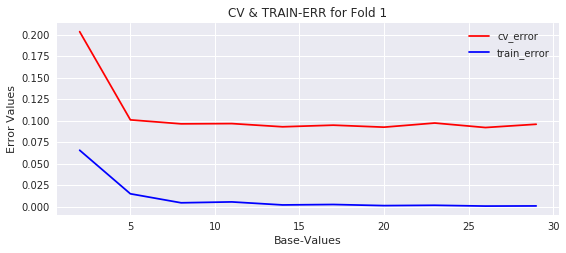

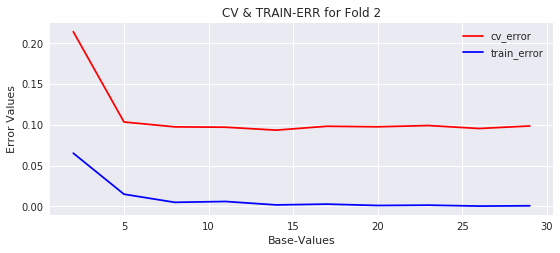

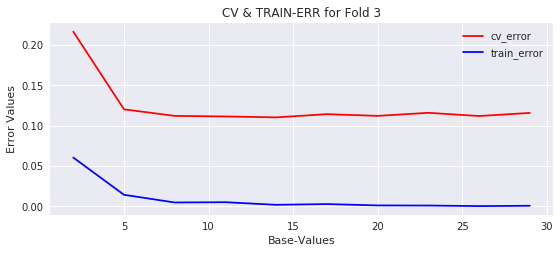

In [31]:
error_comparision(cv_err, train_err)

In [49]:
# applying bow to test and train data 
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [B] Grid Search 

In [33]:
# finding best fit hyper parameters
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=14, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.9376503170322863


### [C] Accuracy Matrics

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '4' is '98.59428571428572'


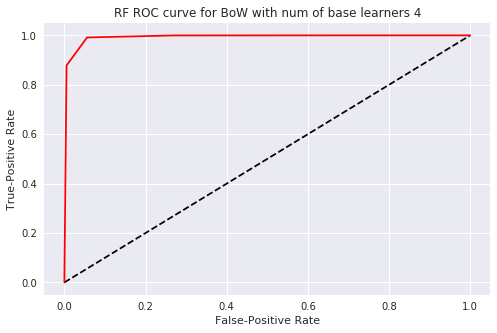

Area under the ROC curve is  0.9926574543114456

Confusion Matrix :
 [[ 7711   457]
 [  527 61305]]

Normalized Confusion Matrix :
 [[0.94404995 0.05595005]
 [0.00852309 0.99147691]]

Precision  : 93.60%, 99.26%
Recall     : 94.40%, 99.15%
F1-score   : [0.94002194 0.99203845]


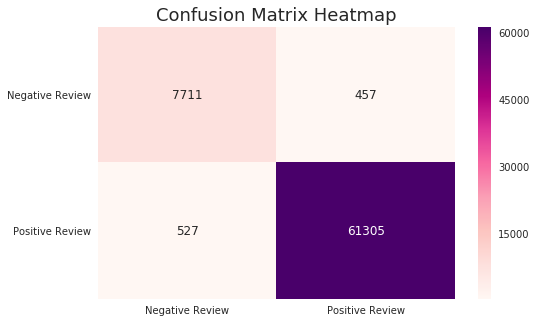







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '4' is '85.92'


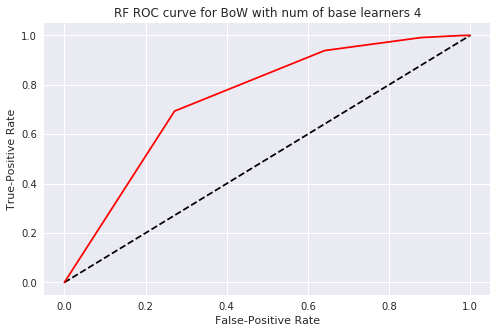

Area under the ROC curve is  0.745682870810762

Confusion Matrix :
 [[ 1471  2632]
 [ 1592 24305]]

Normalized Confusion Matrix :
 [[0.35851816 0.64148184]
 [0.0614743  0.9385257 ]]

Precision  : 48.02%, 90.23%
Recall     : 35.85%, 93.85%
F1-score   : [0.41054982 0.92005148]


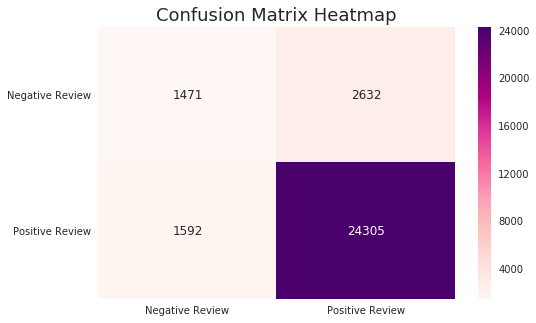

In [34]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 4, 'BoW')

In [35]:
tree_visual(final_counts_train, train_y, count_vect, 4, 'BoW')

BoW_tree1.png
BoW_tree2.png
BoW_tree3.png
BoW_tree4.png


#### Base Estimator(tree) 1
![title](img/BoW_tree1.png)
#### Base Estimator(tree) 2
![title](img/BoW_tree2.png)
#### Base Estimator(tree) 3
![title](img/BoW_tree3.png)
#### Base Estimator(tree) 4
![title](img/BoW_tree4.png)

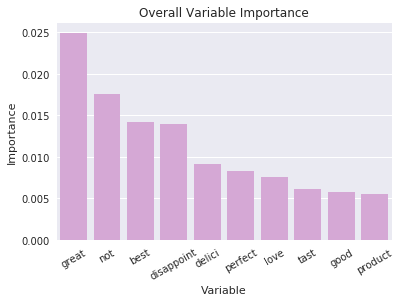

In [36]:
# printing top features(i.e words here)
top_features_overall(final_counts_train, train_y, count_vect, 10, 8)

In [41]:
# printing top features(i.e words here) for each class
top_features_class_wise(final_counts_train, train_y, count_vect, 10, 8)

Top 10 "NEGATIVE" Features are:

labradoodl
conniseur
windowsil
laxat
tres
kim
cinnamoni
ziyad
liptun
with

Top 10 "POSITIVE" Features are:

bought
purchas
year
use
live
day
someth
whole
show
later


### 6.2 XGBoost on BoW

In [42]:
train_err_bow, cv_err_bow = xg_boost(train_x, train_y, count_vect, 'BoW')

In [43]:
cv_err = np.reshape(cv_err_bow,(3, 100))
train_err = np.reshape(train_err_bow,(3, 100))

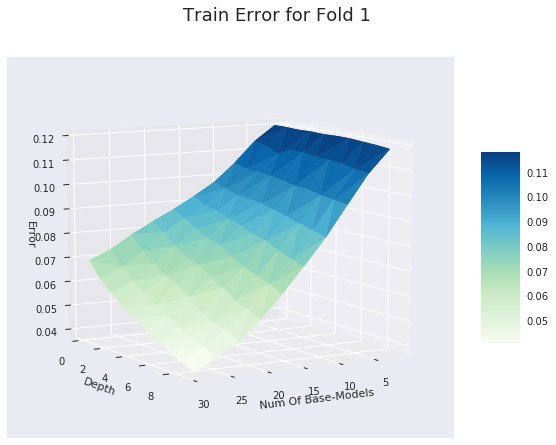

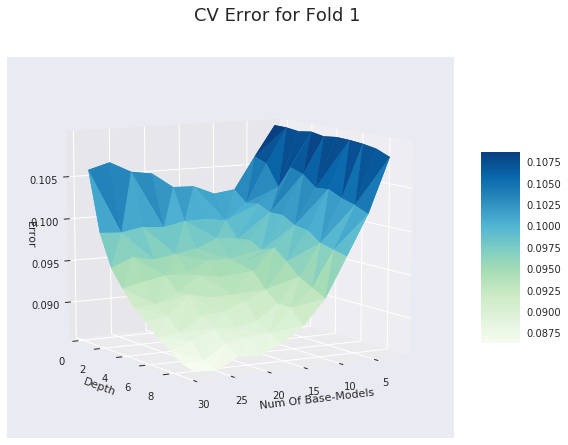

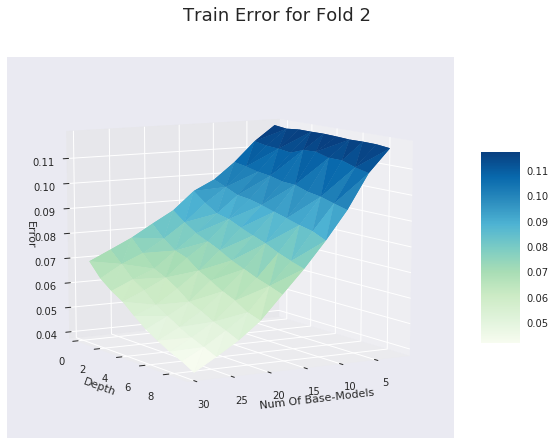

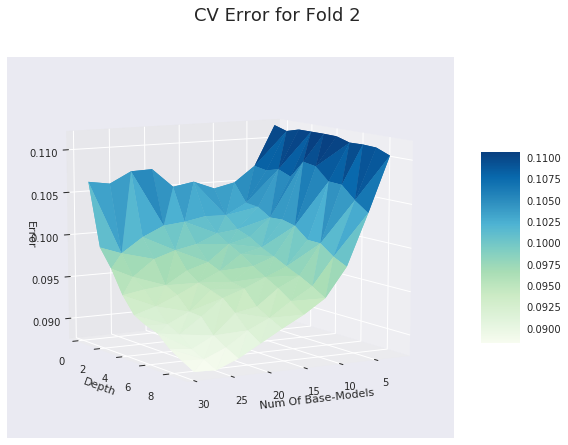

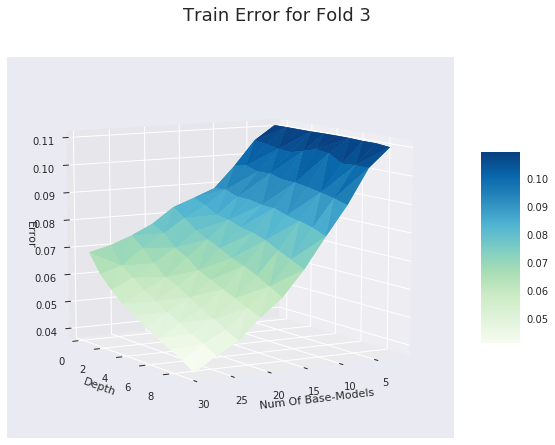

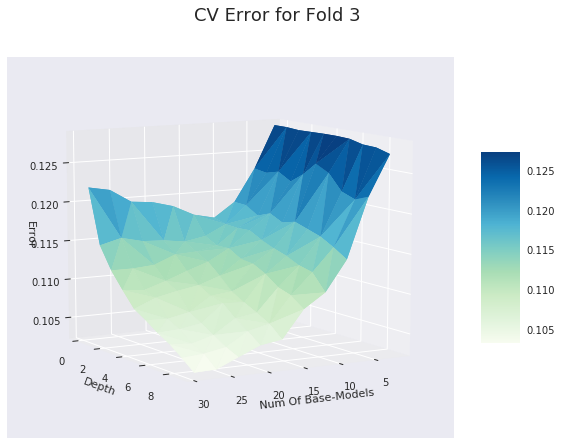

In [44]:
xgb_error_comparision(cv_err, train_err)

In [291]:
# finding best fit hyper parameters
xgb_grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=29, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.9463869463869463


				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '12' is '91.90857142857143'


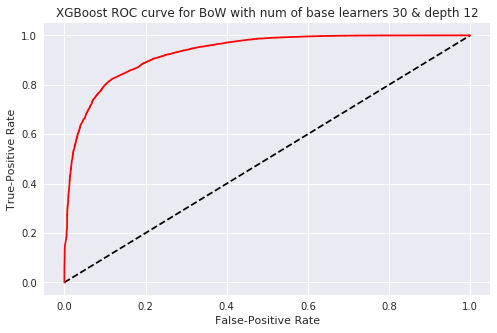

Area under the ROC curve is  0.9309862092033783

Confusion Matrix :
 [[ 2597  5571]
 [   93 61739]]

Normalized Confusion Matrix :
 [[0.31794809 0.68205191]
 [0.00150408 0.99849592]]

Precision  : 96.54%, 91.72%
Recall     : 31.79%, 99.85%
F1-score   : [0.47835697 0.9561413 ]


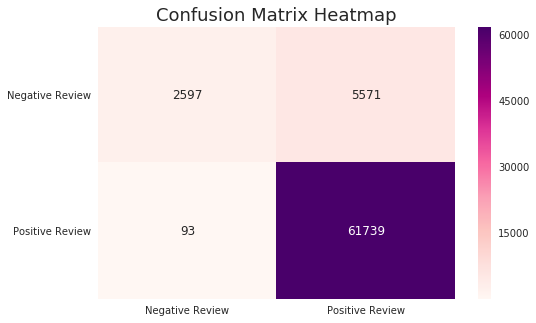







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '12' is '88.94666666666666'


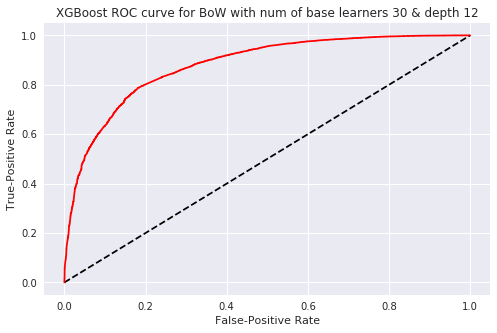

Area under the ROC curve is  0.8791623005744715

Confusion Matrix :
 [[  962  3141]
 [  175 25722]]

Normalized Confusion Matrix :
 [[0.23446259 0.76553741]
 [0.00675754 0.99324246]]

Precision  : 84.61%, 89.12%
Recall     : 23.45%, 99.32%
F1-score   : [0.36717557 0.93944485]


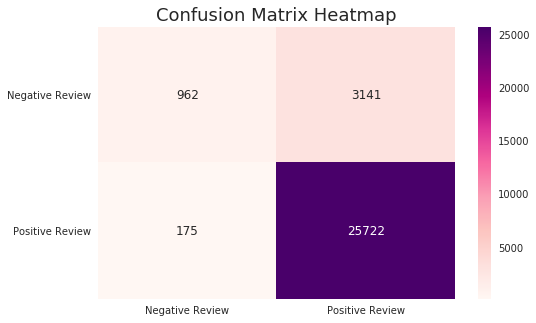

In [50]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 12, 'BoW')

In [ ]:
xgb_tree_visual(final_counJts_train, train_y, count_vect, 30, 4, 'BoW(XGB)')

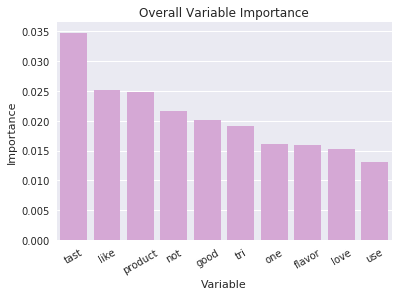

In [51]:
# printing top features(i.e words here)
xgb_top_features_overall(final_counts_train, train_y, count_vect, 10, 30, 12)

In [54]:
xgb_top_features_class_wise(final_counts_train, train_y, count_vect, 10, 30, 12)

Top 10 "NEGATIVE" Features are:

labradoodl
kim
laxat
windowsil
cinnamoni
hiv
alcohol
conniseur
barbaqu
liptun

Top 10 "POSITIVE" Features are:

use
purchas
bought
someth
day
year
see
live
love
turn


In [69]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(min_df=0)

In [32]:
# applying linear svc
train_err, cv_err = random_forest(train_x, train_y, tf_idf_vect, 'TFIDF')

In [34]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

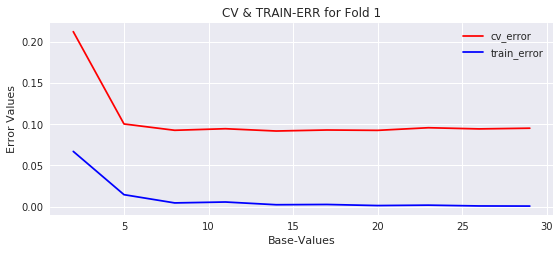

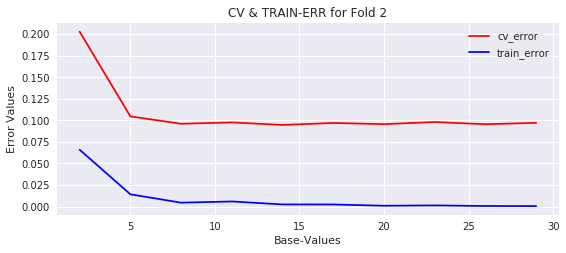

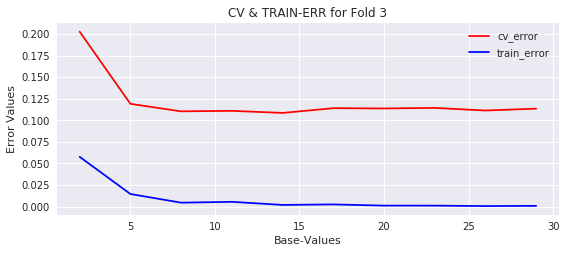

In [35]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

In [70]:
# applying tfidf to test and train data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

In [41]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.9390393975571677


				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '5' is '98.56857142857143'


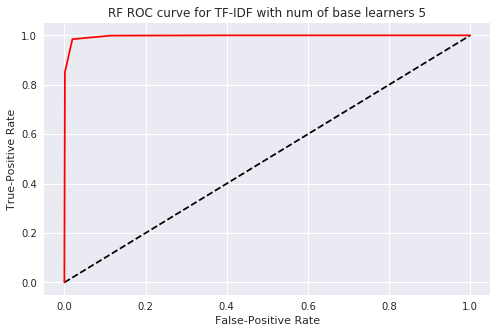

Area under the ROC curve is  0.996776966517849

Confusion Matrix :
 [[ 7235   933]
 [   69 61763]]

Normalized Confusion Matrix :
 [[0.88577375 0.11422625]
 [0.00111593 0.99888407]]

Precision  : 99.06%, 98.51%
Recall     : 88.58%, 99.89%
F1-score   : [0.93523785 0.99195362]


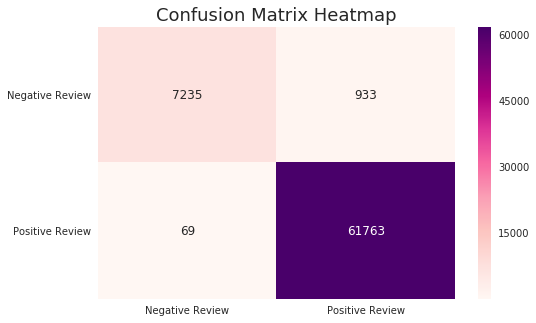







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '5' is '87.79666666666667'


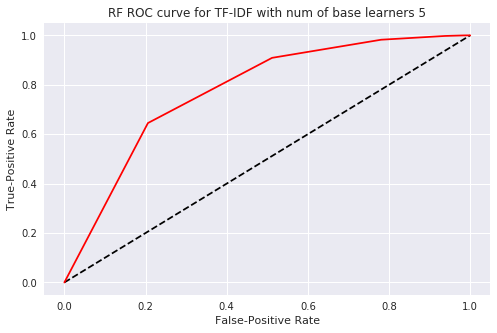

Area under the ROC curve is  0.7760283287649847

Confusion Matrix :
 [[  900  3203]
 [  458 25439]]

Normalized Confusion Matrix :
 [[0.21935169 0.78064831]
 [0.01768545 0.98231455]]

Precision  : 66.27%, 88.82%
Recall     : 21.94%, 98.23%
F1-score   : [0.32960996 0.93287372]


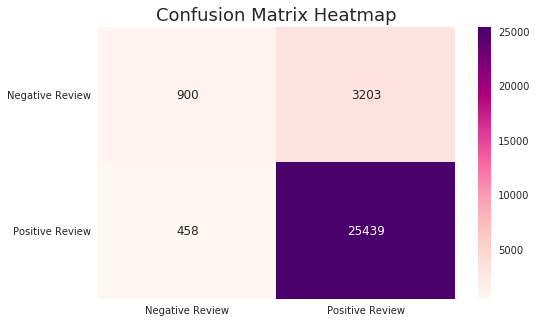

In [37]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 5, 'TF-IDF')

In [38]:
tree_visual(final_counts_train, train_y, tf_idf_vect, 4, 'TFIDF')

TFIDF_tree1.png
TFIDF_tree2.png
TFIDF_tree3.png
TFIDF_tree4.png


#### Base Estimator(tree) 1
![title](img/TFIDF_tree1.png)
#### Base Estimator(tree) 2
![title](img/TFIDF_tree2.png)
#### Base Estimator(tree) 3
![title](img/TFIDF_tree3.png)
#### Base Estimator(tree) 4
![title](img/TFIDF_tree4.png)

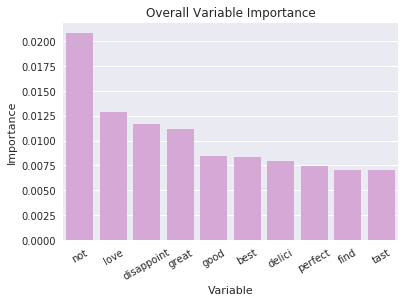

In [39]:
# printing top features(i.e words here)
top_features_overall(final_counts_train, train_y, tf_idf_vect, 10, 5)

In [45]:
# printing top features(i.e words here) for each class
top_features_class_wise(final_counts_train, train_y, tf_idf_vect, 10, 5)

Top 10 "NEGATIVE" Features are:

labradoodl
kim
laxat
windowsil
conniseur
with
alcohol
cinnamoni
liptun
tres

Top 10 "POSITIVE" Features are:

show
bought
year
use
someth
day
along
live
see
purchas


In [46]:
train_err_tfidf, cv_err_tfidf = xg_boost(train_x, train_y, tf_idf_vect, 'TFIDF')

In [48]:
cv_err = np.reshape(cv_err_tfidf,(3, 100))
train_err = np.reshape(train_err_tfidf,(3, 100))

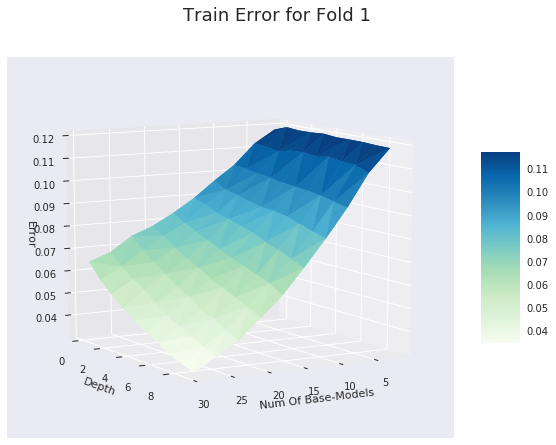

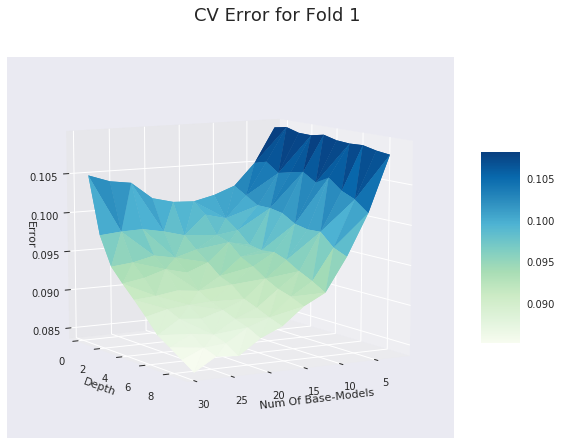

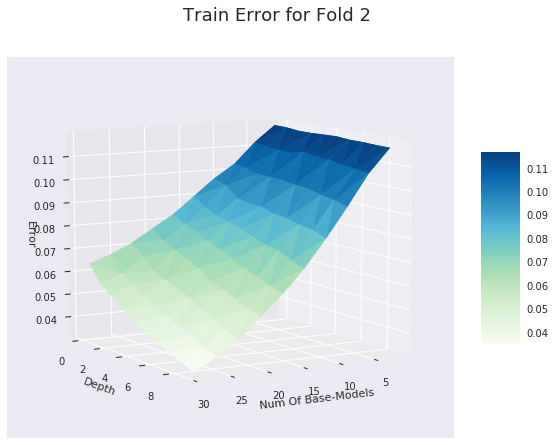

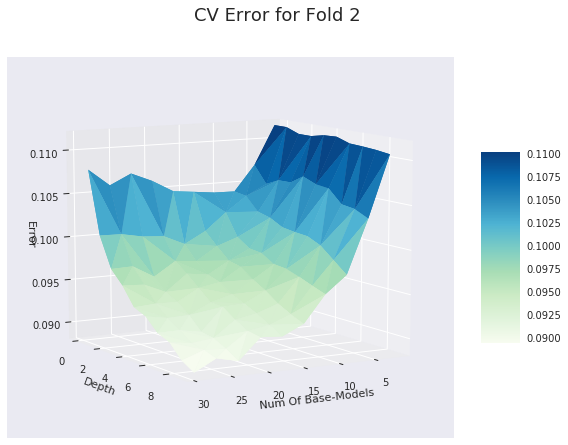

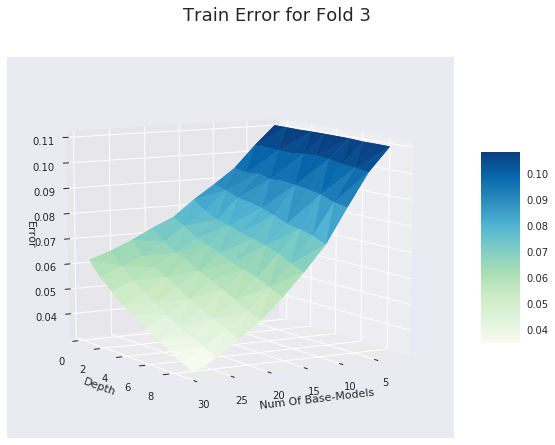

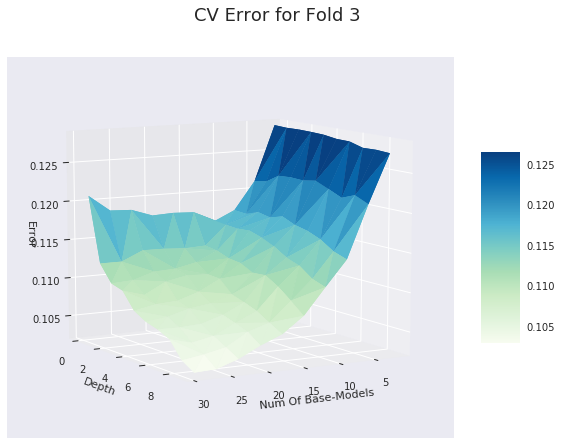

In [49]:
xgb_error_comparision(cv_err, train_err)

In [47]:
# finding best fit hyper parameters
xgb_grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=29, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.9435653424809117


				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '12' is '92.16857142857144'


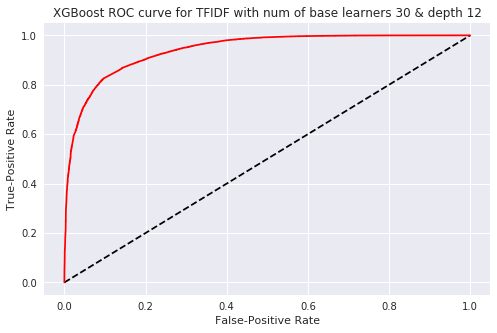

Area under the ROC curve is  0.9411197357276213

Confusion Matrix :
 [[ 2790  5378]
 [  104 61728]]

Normalized Confusion Matrix :
 [[0.34157689 0.65842311]
 [0.00168198 0.99831802]]

Precision  : 96.41%, 91.99%
Recall     : 34.16%, 99.83%
F1-score   : [0.50442958 0.95748344]


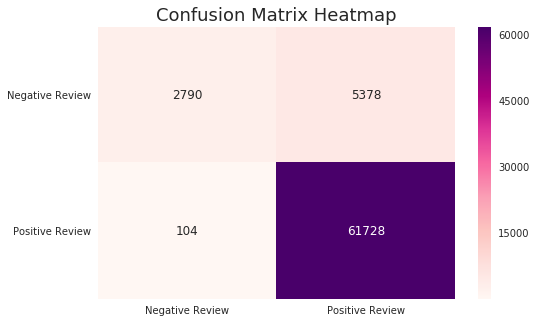







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '12' is '88.96666666666667'


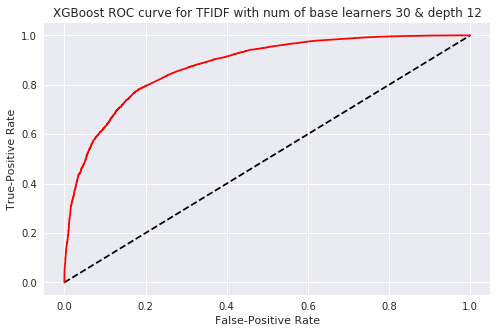

Area under the ROC curve is  0.8776120074698138

Confusion Matrix :
 [[  953  3150]
 [  160 25737]]

Normalized Confusion Matrix :
 [[0.23226907 0.76773093]
 [0.00617832 0.99382168]]

Precision  : 85.62%, 89.10%
Recall     : 23.23%, 99.38%
F1-score   : [0.36541411 0.9395809 ]


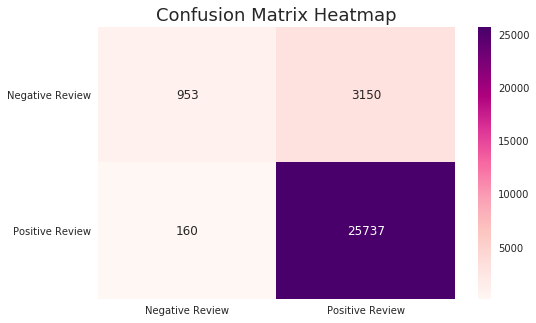

In [50]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 12, 'TFIDF')

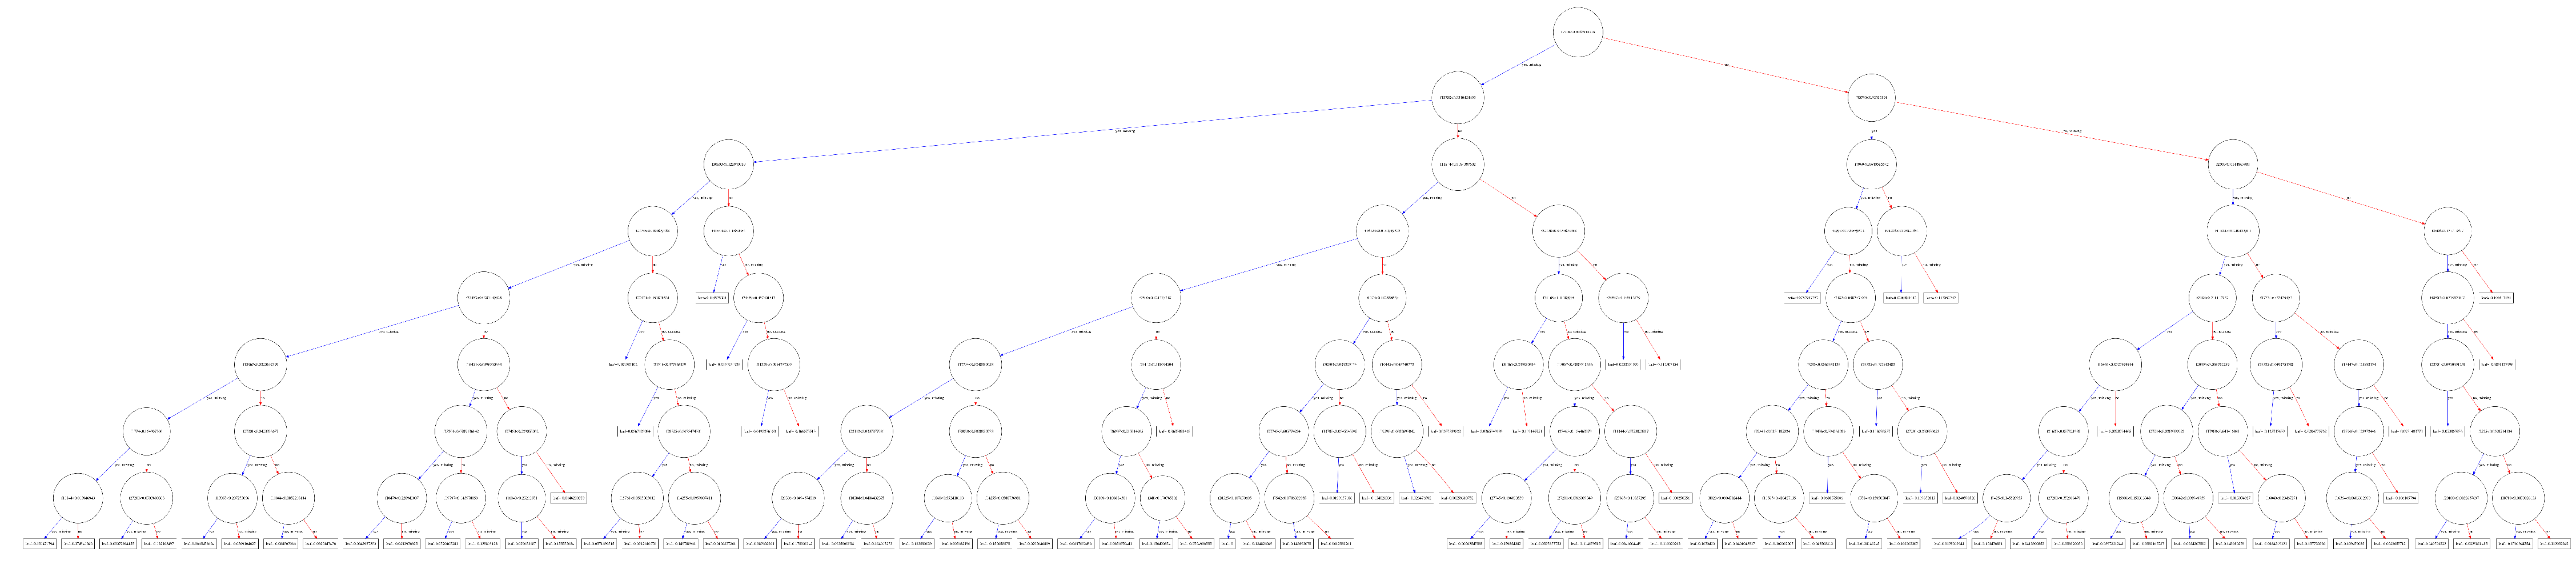

In [67]:
xgb_tree_visual(final_counts_train, train_y, count_vect, 30, 8)

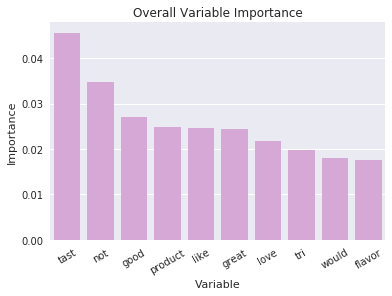

In [78]:
# printing top features(i.e words here)
xgb_top_features_overall(final_counts_train, train_y, tf_idf_vect, 10, 30, 12)

In [79]:
xgb_top_features_class_wise(final_counts_train, train_y, tf_idf_vect, 10, 30, 12)

Top 10 "NEGATIVE" Features are:

labradoodl
kim
laxat
windowsil
hiv
cinnamoni
tranquil
barbaqu
exper
consecr

Top 10 "POSITIVE" Features are:

bought
use
purchas
someth
year
day
see
air
show
love


In [80]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [81]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [82]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [83]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [84]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [85]:
train_x, test_x, train_y, test_y = data_split(list_of_sent[:100000], score[:100000])

In [87]:
# applying linear svc
train_err, cv_err = random_forest(np.array(train_x), np.array(train_y), None, 'Word2Vec')

In [88]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

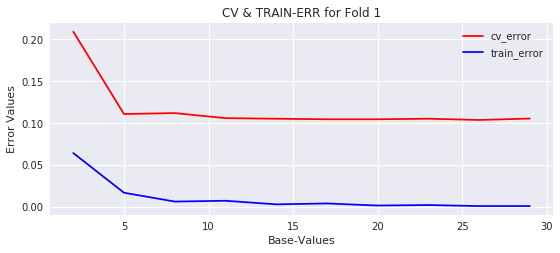

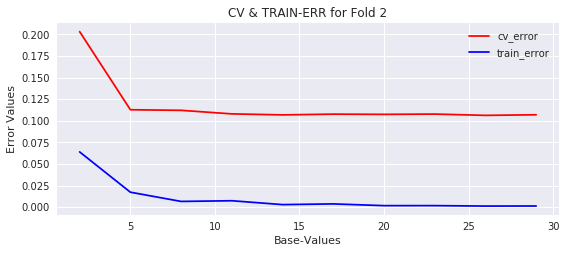

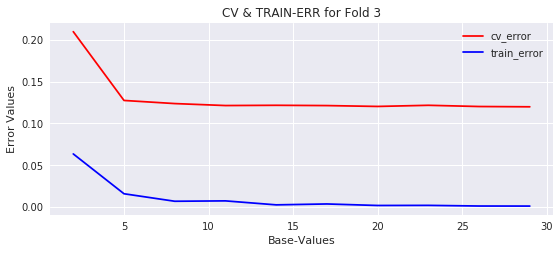

In [89]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

In [90]:
# applying w2v to train and test data
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

In [91]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

In [92]:
# finding best fit alpha using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.9312126800942242


				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '5' is '98.23857142857143'


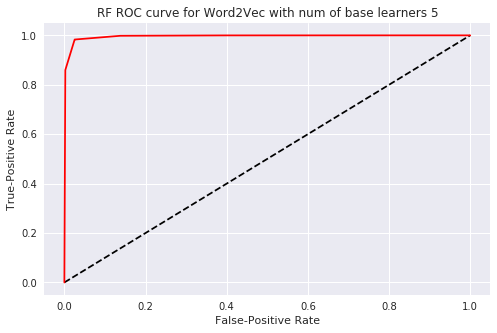

Area under the ROC curve is  0.9955317794075735

Confusion Matrix :
 [[ 7044  1124]
 [  109 61723]]

Normalized Confusion Matrix :
 [[0.86238981 0.13761019]
 [0.00176284 0.99823716]]

Precision  : 98.48%, 98.21%
Recall     : 86.24%, 99.82%
F1-score   : [0.91952222 0.9901106 ]


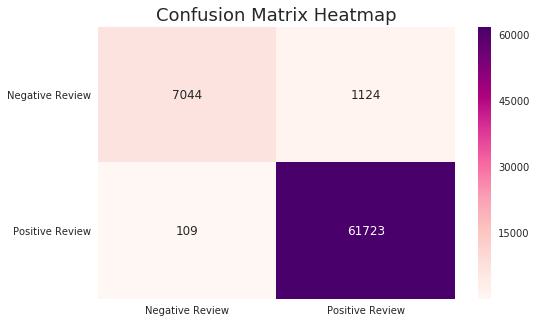







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '5' is '86.79666666666667'


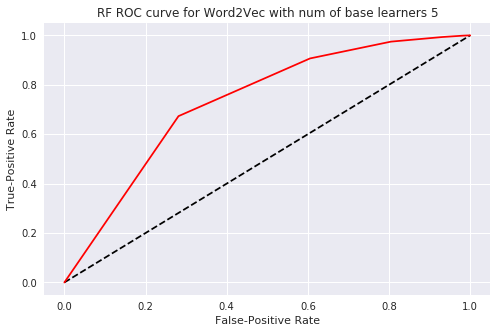

Area under the ROC curve is  0.7311738328646309

Confusion Matrix :
 [[  801  3302]
 [  659 25238]]

Normalized Confusion Matrix :
 [[0.19522301 0.80477699]
 [0.02544696 0.97455304]]

Precision  : 54.86%, 88.43%
Recall     : 19.52%, 97.46%
F1-score   : [0.28797411 0.92723699]


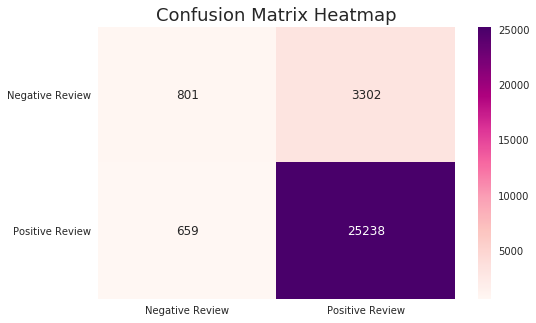

In [96]:
# accuracy measures for train and test data
final_test_acc(train_vect, train_y, test_vect, test_y, 5, 'Word2Vec')

In [98]:
train_err, cv_err = xg_boost(np.array(train_x), np.array(train_y), None, 'Word2Vec')

In [99]:
cv_err = np.reshape(cv_err,(3, 100))
train_err = np.reshape(train_err,(3, 100))

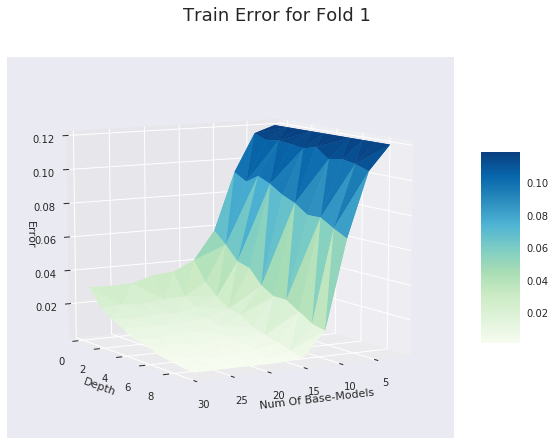

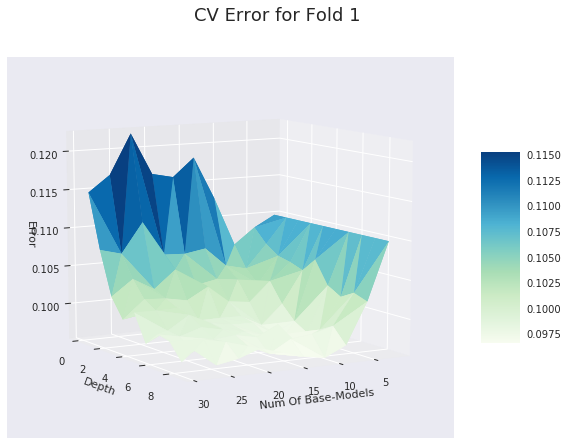

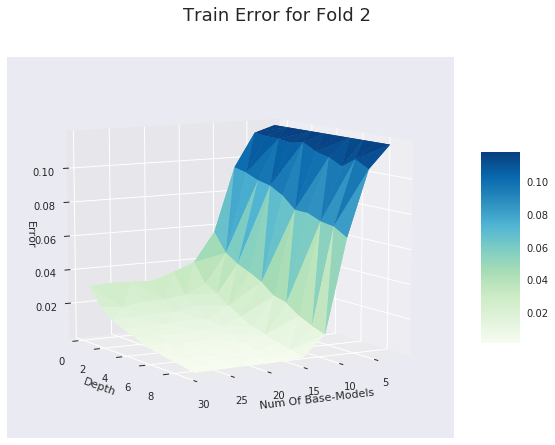

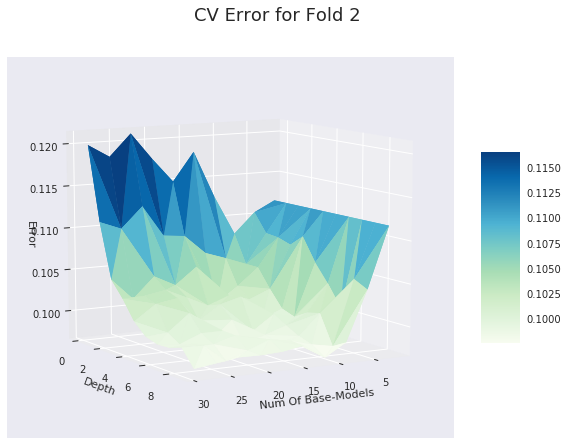

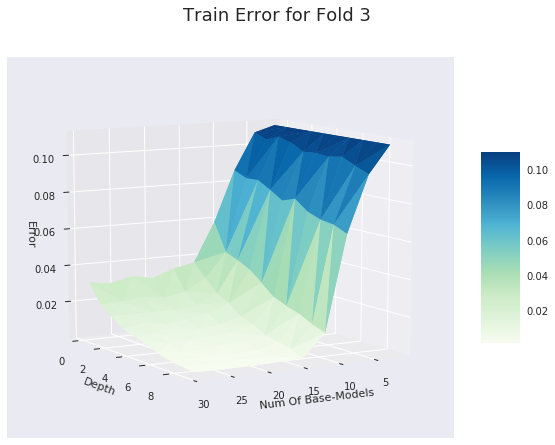

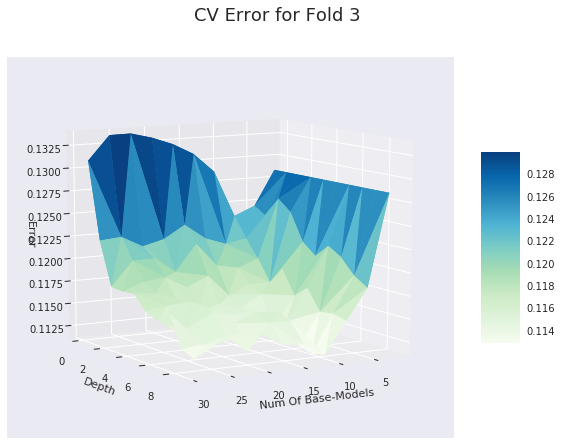

In [100]:
xgb_error_comparision(cv_err, train_err)

In [101]:
# finding best fit hyper parameters
xgb_grid_search_cv(train_vect, train_y, test_vect, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=29,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.935200308307794


				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for num of base learners = '30' and depth = '14' is '86.03857142857143'


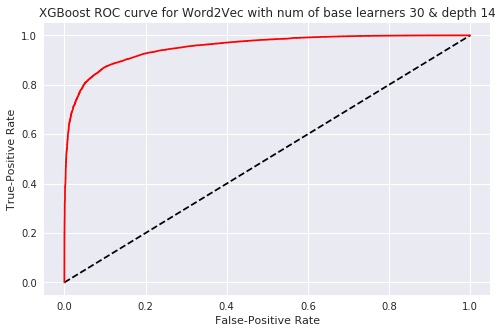

Area under the ROC curve is  0.9522313626136044

Confusion Matrix :
 [[ 7472   696]
 [ 9077 52755]]

Normalized Confusion Matrix :
 [[0.91478942 0.08521058]
 [0.14680101 0.85319899]]

Precision  : 45.15%, 98.70%
Recall     : 91.48%, 85.32%
F1-score   : [0.60460412 0.91522601]


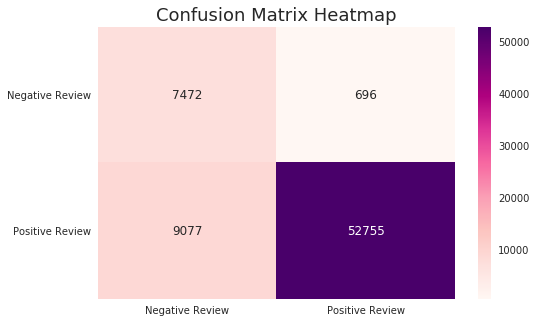







				ACCURACY METRIC FOR TEST-SET


Test accuracy for num of base learners = '30' and depth = '14' is '82.78666666666666'


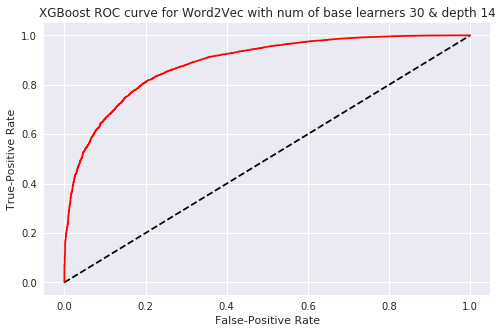

Area under the ROC curve is  0.8868654438436917

Confusion Matrix :
 [[ 3160   943]
 [ 4221 21676]]

Normalized Confusion Matrix :
 [[0.77016817 0.22983183]
 [0.16299185 0.83700815]]

Precision  : 42.81%, 95.83%
Recall     : 77.02%, 83.70%
F1-score   : [0.5503309  0.89356089]


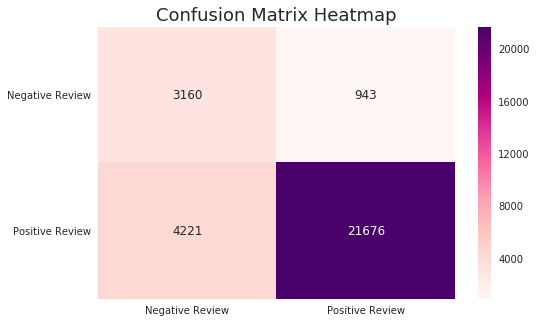

In [111]:
xgb_final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 30, 14, 'Word2Vec')